In [ ]:
df = df[[f'volume_{target_stock}','Bitcoin']]
df_col = df.columns.tolist()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.0 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 22.0 K
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K
8  | static


[INFO] Loading data...
[DEBUG] df shape: (2847, 181), index: 2014-01-02 00:00:00 to 2025-04-28 00:00:00
[DEBUG] df NaN: 0
[DEBUG] features shape : (2847, 12), type: <class 'pandas.core.frame.DataFrame'> 
[DEBUG] features index: 2014-01-02 00:00:00 to 2025-04-28 00:00:00
[DEBUG] features NaN: 0
[DEBUG] full_df shape: (4135, 13), index: 2014-01-02 00:00:00 to 2025-04-28 00:00:00
[DEBUG] full_df NaN after interpolate: 0
[DEBUG] raw_target len: 4135, freq: D, NaNs: 0
[DEBUG] raw_target shape : (4135, 1, 1), type: <class 'darts.timeseries.TimeSeries'> 
[DEBUG] raw_target index-len: 2014-01-02 00:00:00 to 2025-04-28 00:00:00
[DEBUG] raw_covariates shape : (4135, 12, 1), type: <class 'darts.timeseries.TimeSeries'> 
[DEBUG] raw_covariates index-len: 2014-01-02 00:00:00 to 2025-04-28 00:00:00
[INFO] input_len=90, output_len=15, window_step=30, total_len=4135

[INFO] Window 1/5
[DEBUG] train_end=3970, val_start=3880, val_end=3985
[DEBUG] train_target: 2014-01-02 00:00:00 to 2024-11-14 00:00:00,

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 62/62 [00:20<00:00,  3.06it/s, loss=0.0448, train_loss=0.044, val_loss=0.0515]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]
[DEBUG] forecast_p50: 2024-11-30 00:00:00 to 2024-12-14 00:00:00, len=15
[DEBUG] actual: 2024-11-15 00:00:00 to 2024-11-29 00:00:00, len=15


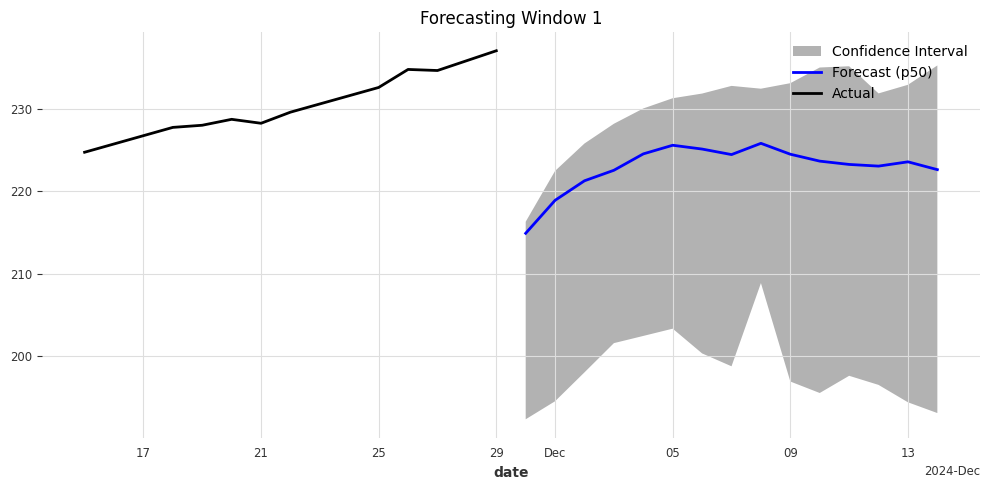

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.0 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 22.0 K
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K
8  | static

[INFO] Final val_loss for window 1: None

[INFO] Window 2/5
[DEBUG] train_end=4000, val_start=3910, val_end=4015
[DEBUG] train_target: 2014-01-02 00:00:00 to 2024-12-14 00:00:00, len=4000
[DEBUG] val_target: 2024-09-16 00:00:00 to 2024-12-29 00:00:00, len=105
[DEBUG] val_covariates: 2024-09-16 00:00:00 to 2025-01-13 00:00:00, len=120
[DEBUG] Scaled train_target shape: (4000, 1, 1), val_target shape: (105, 1, 1)
[DEBUG] Scaled train_covariates shape: (4000, 12, 1), val_covariates shape: (120, 12, 1)
Epoch 1: 100%|██████████| 62/62 [00:22<00:00,  2.80it/s, loss=0.0707, train_loss=0.0563, val_loss=0.141]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 62/62 [00:22<00:00,  2.80it/s, loss=0.0707, train_loss=0.0563, val_loss=0.141]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
[DEBUG] forecast_p50: 2024-12-30 00:00:00 to 2025-01-13 00:00:00, len=15
[DEBUG] actual: 2024-12-15 00:00:00 to 2024-12-29 00:00:00, len=15


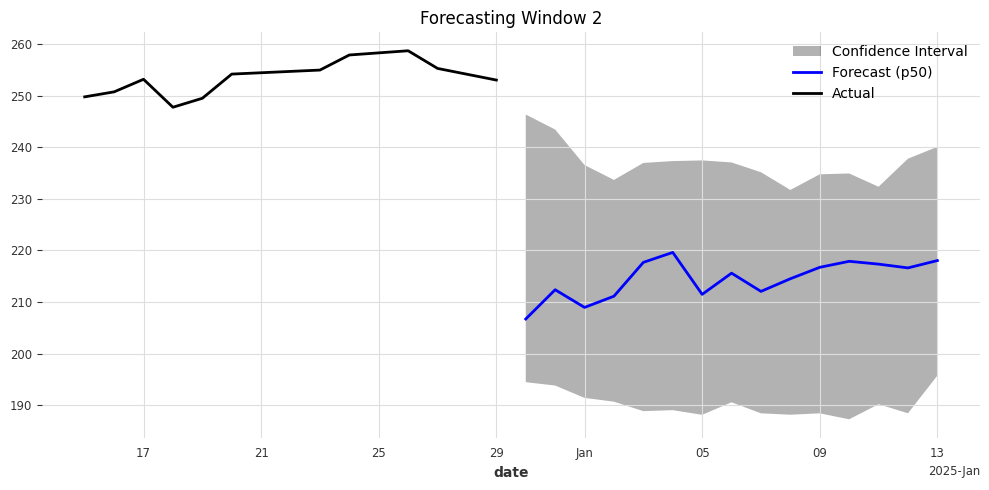

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[INFO] Final val_loss for window 2: None

[INFO] Window 3/5
[DEBUG] train_end=4030, val_start=3940, val_end=4045
[DEBUG] train_target: 2014-01-02 00:00:00 to 2025-01-13 00:00:00, len=4030
[DEBUG] val_target: 2024-10-16 00:00:00 to 2025-01-28 00:00:00, len=105
[DEBUG] val_covariates: 2024-10-16 00:00:00 to 2025-02-12 00:00:00, len=120
[DEBUG] Scaled train_target shape: (4030, 1, 1), val_target shape: (105, 1, 1)
[DEBUG] Scaled train_covariates shape: (4030, 12, 1), val_covariates shape: (120, 12, 1)



   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.0 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 22.0 K
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K
8  | static_context_cell_encoder_grn   | _GatedResidualNetwork            | 16.8 K
9  | static_context_enrichment         | _GatedResidualNetwork            | 16.8

Epoch 1: 100%|██████████| 63/63 [00:22<00:00,  2.85it/s, loss=0.0439, train_loss=0.0388, val_loss=0.0345]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 63/63 [00:22<00:00,  2.85it/s, loss=0.0439, train_loss=0.0388, val_loss=0.0345]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
[DEBUG] forecast_p50: 2025-01-29 00:00:00 to 2025-02-12 00:00:00, len=15
[DEBUG] actual: 2025-01-14 00:00:00 to 2025-01-28 00:00:00, len=15


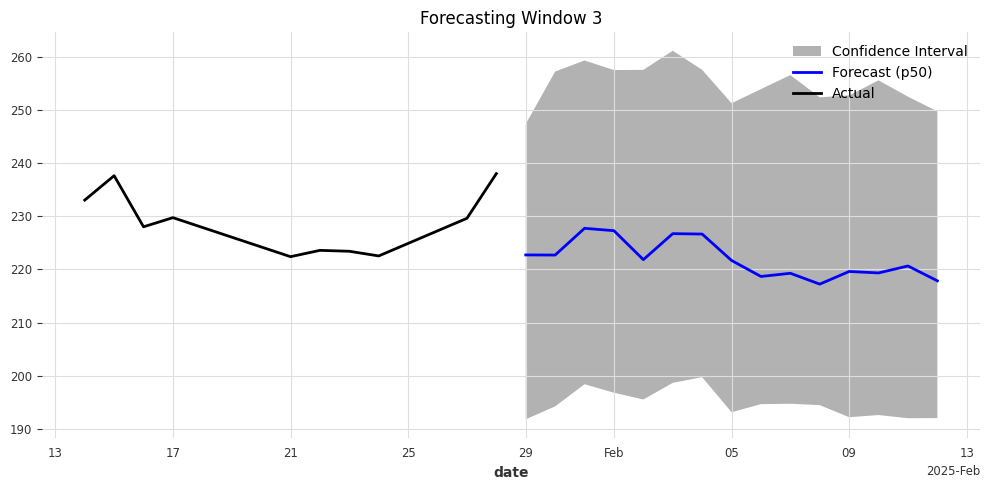

GPU available: True (mps), used: False


[INFO] Final val_loss for window 3: None

[INFO] Window 4/5
[DEBUG] train_end=4060, val_start=3970, val_end=4075
[DEBUG] train_target: 2014-01-02 00:00:00 to 2025-02-12 00:00:00, len=4060
[DEBUG] val_target: 2024-11-15 00:00:00 to 2025-02-27 00:00:00, len=105
[DEBUG] val_covariates: 2024-11-15 00:00:00 to 2025-03-14 00:00:00, len=120
[DEBUG] Scaled train_target shape: (4060, 1, 1), val_target shape: (105, 1, 1)
[DEBUG] Scaled train_covariates shape: (4060, 12, 1), val_covariates shape: (120, 12, 1)


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.0 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 22.0 K
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K
8  | static_context_cell_encoder_grn   | _GatedRes

Epoch 1: 100%|██████████| 63/63 [00:20<00:00,  3.00it/s, loss=0.0448, train_loss=0.0421, val_loss=0.0602]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 63/63 [00:20<00:00,  3.00it/s, loss=0.0448, train_loss=0.0421, val_loss=0.0602]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]
[DEBUG] forecast_p50: 2025-02-28 00:00:00 to 2025-03-14 00:00:00, len=15
[DEBUG] actual: 2025-02-13 00:00:00 to 2025-02-27 00:00:00, len=15


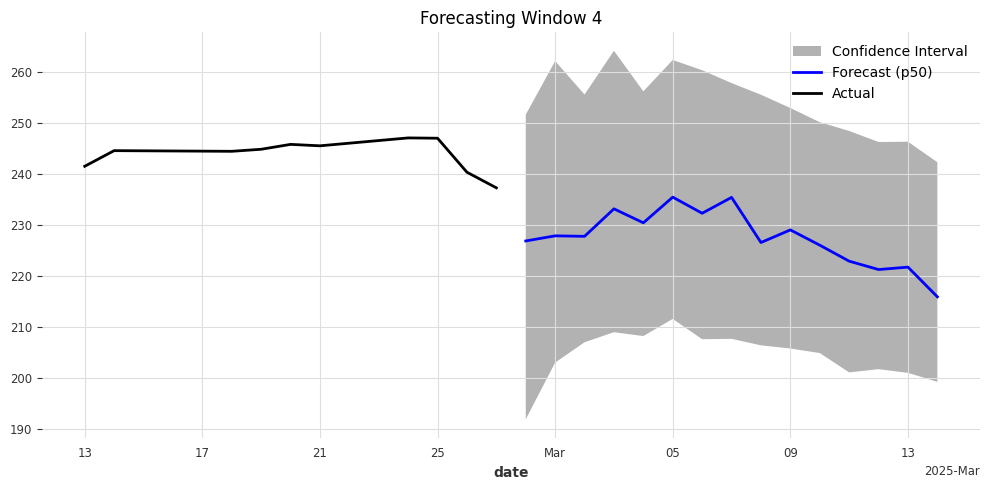

[INFO] Final val_loss for window 4: None

[INFO] Window 5/5
[DEBUG] train_end=4090, val_start=4000, val_end=4105
[DEBUG] train_target: 2014-01-02 00:00:00 to 2025-03-14 00:00:00, len=4090
[DEBUG] val_target: 2024-12-15 00:00:00 to 2025-03-29 00:00:00, len=105
[DEBUG] val_covariates: 2024-12-15 00:00:00 to 2025-04-13 00:00:00, len=120
[DEBUG] Scaled train_target shape: (4090, 1, 1), val_target shape: (105, 1, 1)
[DEBUG] Scaled train_covariates shape: (4090, 12, 1), val_covariates shape: (120, 12, 1)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 24.0 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 22.0 K
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K
8  | static

Epoch 1: 100%|██████████| 64/64 [00:22<00:00,  2.84it/s, loss=0.0532, train_loss=0.0508, val_loss=0.0669]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 64/64 [00:22<00:00,  2.84it/s, loss=0.0532, train_loss=0.0508, val_loss=0.0669]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
[DEBUG] forecast_p50: 2025-03-30 00:00:00 to 2025-04-13 00:00:00, len=15
[DEBUG] actual: 2025-03-15 00:00:00 to 2025-03-29 00:00:00, len=15


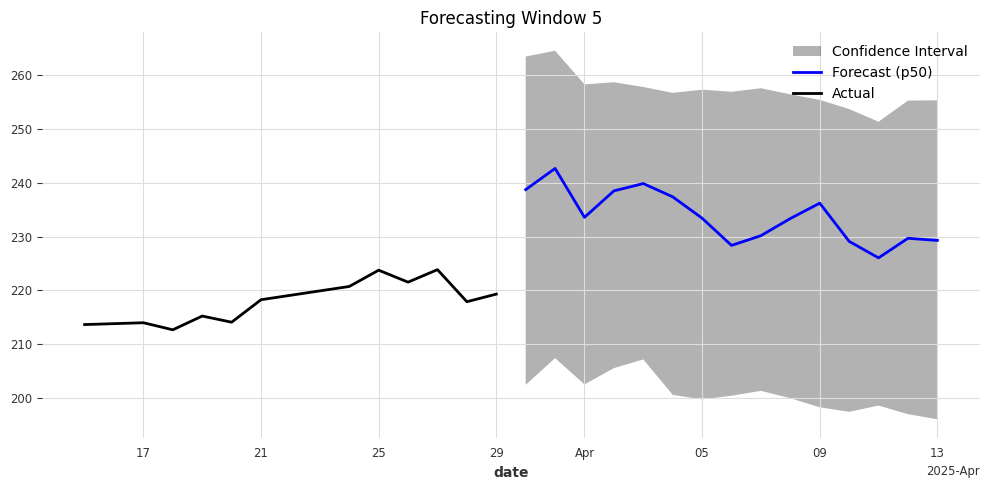

[INFO] Final val_loss for window 5: None

[INFO] Aggregated Performance:
         Window  MAPE  SMAPE  MAE  RMSE   R2  MSE
count  5.000000   0.0    0.0  0.0   0.0  0.0  0.0
mean   3.000000   NaN    NaN  NaN   NaN  NaN  NaN
std    1.581139   NaN    NaN  NaN   NaN  NaN  NaN
min    1.000000   NaN    NaN  NaN   NaN  NaN  NaN
25%    2.000000   NaN    NaN  NaN   NaN  NaN  NaN
50%    3.000000   NaN    NaN  NaN   NaN  NaN  NaN
75%    4.000000   NaN    NaN  NaN   NaN  NaN  NaN
max    5.000000   NaN    NaN  NaN   NaN  NaN  NaN
[INFO] Saved aggregated metrics to 'aggregated_window_metrics.csv'


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
from darts import TimeSeries
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse, smape, mape, r2_score, mse, rmsle
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

warnings.filterwarnings("ignore")

# === Step 1: Load and Prepare Data === #
print("\n[INFO] Step 1: Loading data...")
df = pd.read_csv("../data/Stock_market_data/clean_stock_data_with_time_index.csv", parse_dates=["date"], index_col="date")
df = df.sort_index()
raw_main_df = copy.deepcopy(df)
print(f"[DEBUG] df shape: {df.shape}, index: {df.index.min()} to {df.index.max()}")
print(f"[DEBUG] df NaN: {df.isnull().sum().sum()}")

# === Step 2: Select Target Stock === #
print("\n[INFO] Step 2: Selecting target stock...")
target_stock = "AAPL"
drop_cols = [f"open_{target_stock}", f"low_{target_stock}", f"high_{target_stock}"]
df.drop(columns=drop_cols, inplace=True)
target_df = df[[f"close_{target_stock}"]].rename(columns={f"close_{target_stock}": "target"})
df.drop(columns=f"close_{target_stock}", inplace=True)
df = df[[f'volume_{target_stock}','Bitcoin']]
df_col = df.columns.tolist()


# === Step 3: Time Feature Engineering === #
print("\n[INFO] Step 3: Engineering time features...")
features = pd.DataFrame(index=target_df.index)
features["month"] = features.index.month
features["day_of_week"] = features.index.dayofweek
features["day_of_month"] = features.index.day
features["week"] = features.index.isocalendar().week.values.astype(int)
features["quarter"] = features.index.quarter

def encode_cyclical(df, col, max_val):
    df[f"{col}_sin"] = np.sin(2 * np.pi * df[col] / max_val)
    df[f"{col}_cos"] = np.cos(2 * np.pi * df[col] / max_val)
    df.drop(columns=[col], inplace=True)

for col, max_v in zip(["month", "day_of_week", "day_of_month", "week", "quarter"], [12, 7, 31, 53, 4]):
    encode_cyclical(features, col, max_v)

features = pd.concat([features, df[df_col]], axis=1)
print(f"[DEBUG] features shape : {features.shape}, type: {type(features)} ")
print(f"[DEBUG] features index: {features.index.min()} to {features.index.max()}")
print(f"[DEBUG] features NaN: {features.isnull().sum().sum()}")

# === Step 4: Interpolate Missing Values === #
print("\n[INFO] Step 4: Interpolating missing values...")
full_df = pd.concat([target_df, features], axis=1).resample("D").interpolate(method="linear")
print(f"[DEBUG] full_df shape: {full_df.shape}, index: {full_df.index.min()} to {full_df.index.max()}")
print(f"[DEBUG] full_df NaN after interpolate: {full_df.isnull().sum().sum()}")

# === Step 5: Convert to TimeSeries === #
print("\n[INFO] Step 5: Converting to TimeSeries format...")
raw_target = TimeSeries.from_dataframe(full_df, value_cols="target", freq="D")
raw_covariates = TimeSeries.from_dataframe(full_df, value_cols=features.columns.tolist())
print(f"[DEBUG] raw_target len: {len(raw_target)}, freq: {raw_target.freq_str}, NaNs: {np.isnan(raw_target.values()).sum()}")
print(f"[DEBUG] raw_target shape : {raw_target.shape}, type: {type(raw_target)} ")
print(f"[DEBUG] raw_target index-len: {raw_target.time_index.min()} to {raw_target.time_index.max()}")
print(f"[DEBUG] raw_covariates shape : {raw_covariates.shape}, type: {type(raw_covariates)} ")
print(f"[DEBUG] raw_covariates index-len: {raw_covariates.time_index.min()} to {raw_covariates.time_index.max()}")

# === Step 6: Define Parameters for Sliding Window === #
print("\n[INFO] Step 6: Defining parameters for sliding window...")
output_len = 15
input_len = output_len * 6
num_windows = 5
window_step = 30

if input_len <= output_len:
    raise ValueError("[ERROR] input_len must be greater than output_len to create a valid window.")

print(f"[INFO] input_len={input_len}, output_len={output_len}, window_step={window_step}, total_len={len(raw_target)}")

all_metrics = []

# === Step 7: Loop Over Sliding Windows === #
print("\n[INFO] Step 7: Looping over sliding windows...")
for i in range(num_windows):
    print(f"\n[INFO] Window {i+1}/{num_windows}")

    train_end = len(raw_target) - (num_windows - i) * window_step - output_len
    val_start = train_end - input_len
    val_end = train_end + output_len

    print(f"[DEBUG] train_end={train_end}, val_start={val_start}, val_end={val_end}")

    if val_start < 0 or val_end + output_len > len(raw_target):
        print(f"[WARNING] Skipping window {i+1} due to index bounds.")
        continue

    train_target = raw_target[:train_end]
    val_target = raw_target[val_start:val_end]
    train_covariates = raw_covariates[:train_end]
    val_covariates = raw_covariates[val_start:val_end + output_len]

    print(f"[DEBUG] train_target: {train_target.start_time()} to {train_target.end_time()}, len={len(train_target)}")
    print(f"[DEBUG] val_target: {val_target.start_time()} to {val_target.end_time()}, len={len(val_target)}")
    print(f"[DEBUG] val_covariates: {val_covariates.start_time()} to {val_covariates.end_time()}, len={len(val_covariates)}")

    # === Step 8: Scaling per Window === #
    t_scaler = Scaler()
    f_scaler = Scaler()
    train_target_scaled = t_scaler.fit_transform(train_target)
    val_target_scaled = t_scaler.transform(val_target)
    train_cov_scaled = f_scaler.fit_transform(train_covariates)
    val_cov_scaled = f_scaler.transform(val_covariates)

    print(f"[DEBUG] Scaled train_target shape: {train_target_scaled.shape}, val_target shape: {val_target_scaled.shape}")
    print(f"[DEBUG] Scaled train_covariates shape: {train_cov_scaled.shape}, val_covariates shape: {val_cov_scaled.shape}")

    # === Step 9: Model Definition === #
    model = TFTModel(
        input_chunk_length=input_len,
        output_chunk_length=output_len,
        hidden_size=64,
        lstm_layers=2,
        dropout=0.3,
        batch_size=64,
        n_epochs=2,
        num_attention_heads=4,
        likelihood=QuantileRegression([0.1, 0.5, 0.9]),
        pl_trainer_kwargs={"callbacks": [EarlyStopping(monitor="val_loss", patience=3)]},
        force_reset=True
    )

    model.fit(train_target_scaled, future_covariates=train_cov_scaled,
              val_series=val_target_scaled, val_future_covariates=val_cov_scaled, verbose=True)

    # === Step 10: Forecasting === #
    forecast = model.predict(n=output_len, series=val_target_scaled,
                             future_covariates=val_cov_scaled, num_samples=100)
    forecast_p10 = t_scaler.inverse_transform(forecast.quantile_timeseries(0.1))
    forecast_p50 = t_scaler.inverse_transform(forecast.quantile_timeseries(0.5))
    forecast_p90 = t_scaler.inverse_transform(forecast.quantile_timeseries(0.9))

    # === Step 11: Evaluate === #
    actual = val_target[-output_len:]
    print(f"[DEBUG] forecast_p50: {forecast_p50.start_time()} to {forecast_p50.end_time()}, len={len(forecast_p50)}")
    print(f"[DEBUG] actual: {actual.start_time()} to {actual.end_time()}, len={len(actual)}")

    if len(actual) == 0 or len(forecast_p50) == 0:
        print(f"[WARNING] Skipping metrics for window {i+1}: No valid forecast or target data.")
        continue

    metrics = {
        "Window": i + 1,
        "MAPE": mape(actual, forecast_p50),
        "SMAPE": smape(actual, forecast_p50),
        "MAE": mae(actual, forecast_p50),
        "RMSE": rmse(actual, forecast_p50),
        "R2": r2_score(actual, forecast_p50),
        "MSE": mse(actual, forecast_p50)
    }
    all_metrics.append(metrics)

    # === Step 12: Confidence Interval Plot === #
    plt.figure(figsize=(10, 5))
    plt.fill_between(forecast_p50.time_index, forecast_p10.values().squeeze(), forecast_p90.values().squeeze(), alpha=0.3, label="Confidence Interval")
    forecast_p50.plot(label="Forecast (p50)", color="blue")
    actual.plot(label="Actual", color="black")
    plt.title(f"Forecasting Window {i+1}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Step 13: Loss Curve === #
    if hasattr(model.trainer, 'callback_metrics'):
        loss = model.trainer.callback_metrics
        print(f"[INFO] Final val_loss for window {i+1}: {loss.get('val_loss')}")

# === Step 14: Aggregate Performance === #
metrics_df = pd.DataFrame(all_metrics)
print("\n[INFO] Aggregated Performance:")
print(metrics_df.describe())

# === Step 15: Save Metrics === #
metrics_df.to_csv("aggregated_window_metrics.csv", index=False)
print("[INFO] Saved aggregated metrics to 'aggregated_window_metrics.csv'")
